# Prithvi WxC Downscaling with ECCC Data: Model Fine-tuning

This notebook is a walk through to use the `Prithvi` downscaling model for fine-tuning using the `ECCC` data

We show how to initalize the model, load the pretrained weights, and finetune it

To replicate the results show in this notebook please download the required files from our [Hugging Face](https://huggingface.co/ibm-granite/granite-geospatial-wxc-downscaling) repository

In [1]:
from huggingface_hub import snapshot_download
import os

if not os.path.exists('granite-geospatial-wxc-downscaling'):
    snapshot_download(repo_id='ibm-granite/granite-geospatial-wxc-downscaling', allow_patterns="*", repo_type='model', local_dir='./granite-geospatial-wxc-downscaling')

/home/simon/miniconda3/envs/fm4a/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**This notebook is a simple plug-and-play example** 

We provide only **1 data sample**. See `./examples/eccc_downscaling/notebooks/README.md` to download and preprocess the remaining files

In [2]:
import logging
import warnings
logging.disable(logging.CRITICAL)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import os
import torch

from granitewxc.utils.config import get_config
from granitewxc.utils.distributed import init_ddp
from granitewxc.utils.eccc_data import get_dataloaders_eccc
from granitewxc.models.model import get_finetune_model_UNET, get_finetune_model
from granitewxc.utils.plot import plot_sample, plot_loss

Pysteps configuration file found at: /home/simon/miniconda3/envs/fm4a/lib/python3.12/site-packages/pysteps/pystepsrc



Configure the backends and torch states

In [4]:
torch.jit.enable_onednn_fusion(True)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
torch.manual_seed(123)

It is possible to use a cpu or gpu/s to generate inferences. Based on avaiablity of a `cuda:gpu`, we set the device that the model uses

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    use_gpu = True
else:
    device = torch.device('cpu')
    use_gpu = False

We initialize the Distributed Data Parallel (DDP) environment to leverage multiple GPUs for training

In [6]:
os.environ["LOCAL_RANK"] = "0"
os.environ["RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "2468"

local_rank, rank = init_ddp(use_gpu=use_gpu)

## Configuration File

The model is configured using `YAML` files.

In these files, you specify:
- Paths to the input data  
- Locations of the pretrained weights  

To ensure compatibility with the provided weights during inference, keep the model configuration consistent with the original definitions 

In [7]:
config_path = './granite-geospatial-wxc-downscaling/ECCC/configs/config_UNET.yaml'
config = get_config(config_path)

## Dataloader 

In this example we will use only **1 sample of data**

To download and setup all the remaining data follow the instructions in `./examples/eccc_downscaling/notebooks/README.md`"

In [8]:
train_dl, val_dl = get_dataloaders_eccc(config)

--> Training batches: 16
--> Validation batches: 16
--> Training samples: 16
--> Validation samples: 16


### Train data

The ECCC data corresponds to the entire Canadian region

For training, we adopt a strategy that randomly crops the data into patches of fixed width and height, which are then used to train the model. For inference we will use the entire region...

You can adjust the size and number of crops in the configuration file

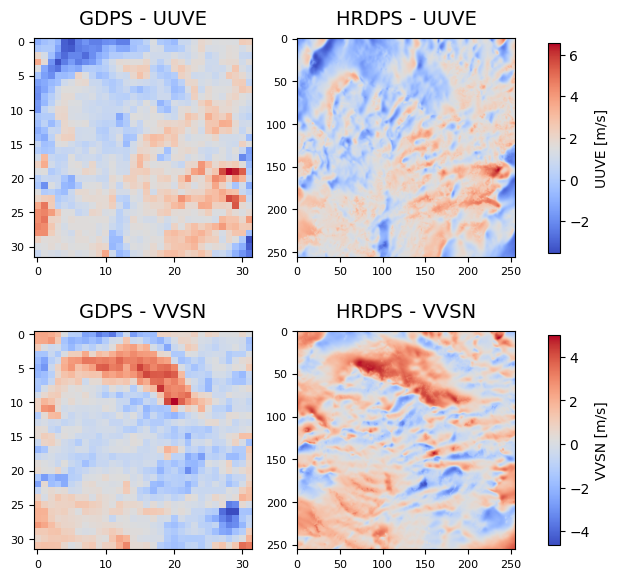

In [9]:
plot_sample(next(iter(train_dl)))

## Model Initialization

We provide **2** different model architectures `UNET-like` and `CONV` 

Both architectures include:  
1. **Patch Embedding**: Extracts shallow features from the input data  
2. **Feature Extraction**: Utilizes the Prithvi backbone to extract deeper features  

The key difference is that the UNET-like version incorporates **static high-resolution data** into the model

In this notebook, we use the **UNET-like** version

To switch to the **CONV** model, update the configuration file accordingly and use `get_finetune_model(config)` 

In [10]:
model = get_finetune_model_UNET(config)

Creating the model.
--> model has 1,448,690,568 params.


We can now load the pretrained weights

In [11]:
weights_path = config.path_model_weights
weights = torch.load(weights_path, map_location=device)['model']

model.load_state_dict(weights, strict=True)
model.to(device)

ClimateDownscaleFinetuneUNETModel(
  (backbone): PrithviWxCEncoderDecoder(
    (lgl_block): LocalGlobalLocalBlock(
      (transformers): ModuleList(
        (0-16): 17 x Transformer(
          (drop_path): Identity()
          (attention): Sequential(
            (0): LayerNormPassThrough((2560,), eps=1e-05, elementwise_affine=True)
            (1): MultiheadAttention(
              (qkv_layer): Linear(in_features=2560, out_features=7680, bias=False)
              (w_layer): Linear(in_features=2560, out_features=2560, bias=False)
            )
          )
          (ff): Sequential(
            (0): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
            (1): Mlp(
              (net): Sequential(
                (0): Linear(in_features=2560, out_features=10240, bias=True)
                (1): GELU(approximate='none')
                (2): Dropout(p=0.0, inplace=False)
                (3): Linear(in_features=10240, out_features=2560, bias=True)
                (4): Dropout(p=0

## Finetuning

The model is now ready for training

In [12]:
from torch.optim import AdamW
from torch.cuda.amp import GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR

from granitewxc.utils.trainer import train_model
from granitewxc.models.loss import rmse_loss

## 
Defining the optimizer, scaler, and scheduler for the training process.

In [13]:
optimizer = AdamW(model.parameters(), lr=config.learning_rate)
scaler = GradScaler()
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=config.num_epochs * min(len(train_dl), config.limit_steps_train),
    eta_min=config.min_lr,
)
save_every = 5

We'll train the model using just 1 data pair and run it for only 5 epochs

Let's train it for a couple of epochs based on the configuration file

In [14]:
train_losses, val_losses = train_model(
    config, model, train_dl, val_dl, optimizer, scheduler, scaler, local_rank, use_gpu, save_every, rmse_loss
)

/home/simon/miniconda3/envs/fm4a/lib/python3.12/site-packages/torch/distributed/distributed_c10d.py:4807: UserWarning: No device id is provided via `init_process_group` or `barrier `. Using the current device set by the user. 
  warnings.warn(  # warn only once
[rank0]:[W905 11:33:32.035082662 ProcessGroupNCCL.cpp:5023] [PG ID 0 PG GUID 0 Rank 0]  using GPU 0 as device used by this process is currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect. You can specify device_id in init_process_group() to force use of a particular device.


Learning rate: 1e-05
Rank 0 starting epoch 1...


Validation Epoch: 100%|██████████████████████████████████| 16/16 [00:00<00:00, 18.20batch/s, loss=0.824]


Learning rate: 9.779754323328193e-06
Rank 0 starting epoch 2...


Validation Epoch: 100%|██████████████████████████████████| 16/16 [00:00<00:00, 18.09batch/s, loss=0.787]


Learning rate: 9.140576474687263e-06
Rank 0 starting epoch 3...


Validation Epoch: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 17.72batch/s, loss=1.16]


Learning rate: 8.145033635316128e-06
Rank 0 starting epoch 4...


Validation Epoch: 100%|██████████████████████████████████| 16/16 [00:00<00:00, 17.92batch/s, loss=0.645]


Learning rate: 6.890576474687265e-06
Rank 0 starting epoch 5...


Validation Epoch: 100%|██████████████████████████████████| 16/16 [00:00<00:00, 17.92batch/s, loss=0.666]


--> saved ./granite-geospatial-wxc-downscaling/ECCC/weights/checkpoint_4.pt
Learning rate: 5.5000000000000016e-06
Rank 0 starting epoch 6...


Validation Epoch: 100%|██████████████████████████████████| 16/16 [00:00<00:00, 18.05batch/s, loss=0.808]


Learning rate: 4.109423525312741e-06
Rank 0 starting epoch 7...


Validation Epoch: 100%|██████████████████████████████████| 16/16 [00:00<00:00, 19.63batch/s, loss=0.687]


Learning rate: 2.8549663646838763e-06
Rank 0 starting epoch 8...


Validation Epoch: 100%|██████████████████████████████████| 16/16 [00:00<00:00, 19.28batch/s, loss=0.726]


Learning rate: 1.8594235253127394e-06
Rank 0 starting epoch 9...


Validation Epoch: 100%|██████████████████████████████████| 16/16 [00:00<00:00, 19.02batch/s, loss=0.685]


Learning rate: 1.2202456766718099e-06
Rank 0 starting epoch 10...


Validation Epoch: 100%|██████████████████████████████████| 16/16 [00:00<00:00, 19.02batch/s, loss=0.783]


--> saved ./granite-geospatial-wxc-downscaling/ECCC/weights/checkpoint_9.pt


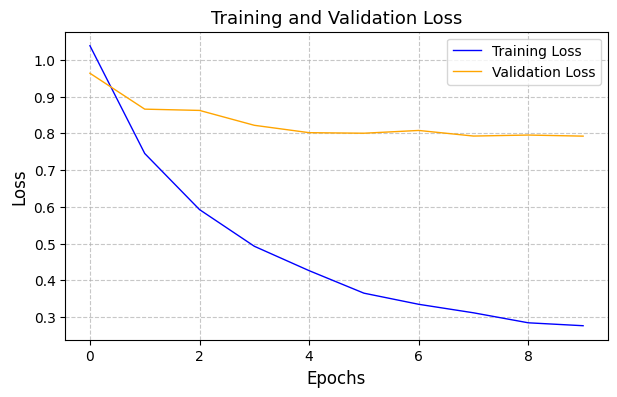

In [15]:
plot_loss(train_losses, val_losses)